In [37]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
q='''select *
from change_complexity cc
join advisory a on cc.advisory_id = a.id
join package p on a.package_id = p.id;'''
df = pd.DataFrame(sql.execute(q)) 
df

,advisory_id,release_id,commit_count,file_count,loc_change,author_count,related_commits,release_type,id,type,...,severity,cvss3_score,cvss3_vector,credit,disclose_date,publish_date,p.id,name,ecosystem,repository_url
0,SNYK-JS-ABSOLUNETKAFE-1017403,1,2,75,187,1,None,patch,SNYK-JS-ABSOLUNETKAFE-1017403,Regular Expression Denial of Service (ReDoS),...,M,5.3,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:L,Yeting Li,2020-10-14,2020-11-05,356,@absolunet/kafe,npm,https://github.com/absolunet/kafe
1,SNYK-JS-APOLLOGATEWAY-174915,4,2,4,67,1,None,patch,SNYK-JS-APOLLOGATEWAY-174915,Prototype Pollution,...,H,7.3,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:L/I:L/A:L,Trevor Scheer,2019-06-04,2019-06-05,1852,@apollo/gateway,npm,https://github.com/apollographql/federation/tr...
2,SNYK-JS-AWSSDKSHAREDINIFILELOADER-1049304,5,13,777,218447,5,None,prerelease,SNYK-JS-AWSSDKSHAREDINIFILELOADER-1049304,Prototype Pollution,...,H,7.3,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:L/I:L/A:L/E:P,"Eugene Lim, Government Technology Agency Cyber...",2021-01-14,2021-01-14,3892,@aws-sdk/shared-ini-file-loader,npm,https://github.com/aws/aws-sdk-js-v3/tree/mast...
3,SNYK-JS-CKEDITORCKEDITOR5LINK-72892,7,11,5,186,1,None,patch,SNYK-JS-CKEDITORCKEDITOR5LINK-72892,Cross-site Scripting (XSS),...,M,6.5,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,Unknown,2018-05-22,2019-08-27,1628,@ckeditor/ckeditor5-link,npm,https://github.com/ckeditor/ckeditor5/tree/mas...
4,SNYK-JS-CKEDITORCKEDITOR5MARKDOWNGFM-1066168,8,301,1114,24697,18,None,major,SNYK-JS-CKEDITORCKEDITOR5MARKDOWNGFM-1066168,Regular Expression Denial of Service (ReDoS),...,H,7.5,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,Erik Krogh Kristensen,2021-01-29,2021-01-31,3916,@ckeditor/ckeditor5-markdown-gfm,npm,https://github.com/ckeditor/ckeditor5/tree/mas...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,SNYK-JS-YARN-451571,852,3,3,49,1,None,patch,SNYK-JS-YARN-451571,Man-in-the-Middle (MitM),...,H,8.2,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:L/A:H/E...,Сковорода Никита Андреевич,2019-07-12,2019-07-15,3598,yarn,npm,https://github.com/yarnpkg/yarn
643,SNYK-JS-YARN-548869,853,11,20,376,6,None,minor,SNYK-JS-YARN-548869,Arbitrary File Overwrite,...,M,6.1,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:N/I:H/A:N/E...,Rhys Elsmore,2020-02-15,2020-02-15,3598,yarn,npm,https://github.com/yarnpkg/yarn
644,SNYK-JS-ZENNCLI-1024443,855,3,6,17,1,None,patch,SNYK-JS-ZENNCLI-1024443,Directory Traversal,...,M,4.3,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:L/I:N/A:N/E...,ryotak,2020-10-29,2020-11-16,258,zenn-cli,npm,https://github.com/zenn-dev/zenn-editor
645,npm:zeroclipboard:20120528,856,7,11,143,1,None,patch,npm:zeroclipboard:20120528,Cross-site Scripting (XSS),...,M,4.3,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:L/A:N,Kingfo,2012-05-27,2017-03-13,2842,zeroclipboard,npm,https://github.com/zeroclipboard/zeroclipboard


In [39]:
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')[['release_id']].count()
commits =df.groupby('ecosystem')[['commit_count']].median()
files = df.groupby('ecosystem')[['file_count']].median()
loc = df.groupby('ecosystem')[['loc_change']].median()
contributors = df.groupby('ecosystem')[['author_count']].median()

In [40]:
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel, commits, files, loc, contributors])
final

,advisory_id,package_id,release_id,commit_count,file_count,loc_change,author_count
ecosystem,,,,,,,
npm,536,362,647,7,11,489,2


In [41]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{rrrrrrr}
\hline
   advisory\_id &   package\_id &   release\_id &   commit\_count &   file\_count &   loc\_change &   author\_count \\
\hline
           536 &          362 &          647 &              7 &           11 &          489 &              2 \\
\hline
\end{tabular}


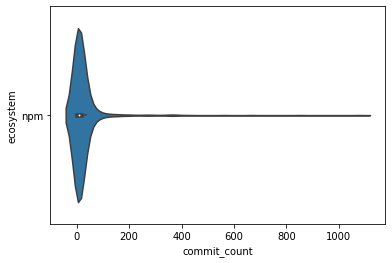

In [42]:
ax = sns.violinplot(x='commit_count', y='ecosystem', data = df)
plt.savefig('commit_complexity.png')